Import Libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")


Load datasets

In [85]:


sentiment_df = pd.read_csv("fear_greed_index.csv")
trades_df = pd.read_csv("historical_data.csv")


Basic Data Inspection

In [86]:
sentiment_df.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [87]:
sentiment_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [88]:
sentiment_df.isnull().sum()


,0
timestamp,0
value,0
classification,0
date,0


In [89]:
trades_df.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [90]:
trades_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82589 entries, 0 to 82588
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Account           82589 non-null  object 
 1   Coin              82589 non-null  object 
 2   Execution Price   82589 non-null  float64
 3   Size Tokens       82589 non-null  float64
 4   Size USD          82589 non-null  float64
 5   Side              82589 non-null  object 
 6   Timestamp IST     82589 non-null  object 
 7   Start Position    82589 non-null  float64
 8   Direction         82589 non-null  object 
 9   Closed PnL        82589 non-null  float64
 10  Transaction Hash  82589 non-null  object 
 11  Order ID          82589 non-null  int64  
 12  Crossed           82589 non-null  bool   
 13  Fee               82589 non-null  float64
 14  Trade ID          82589 non-null  float64
 15  Timestamp         82589 non-null  float64
dtypes: bool(1), float64(8), int64(1), object

In [91]:
trades_df.isnull().sum()


,0
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0
Direction,0
Closed PnL,0


Data Cleaning

In [99]:
sentiment_df = sentiment_df.drop_duplicates().dropna()
trades_df = trades_df.drop_duplicates().dropna()


Standardize Column Names

In [119]:
sentiment_df.columns = sentiment_df.columns.str.lower().str.strip()
trades_df.columns = trades_df.columns.str.lower().str.strip()

Convert timestamps to datetime

In [114]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.floor('D')


In [115]:
trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp'])
trades_df['date'] = trades_df['timestamp'].dt.floor('D')


Process Sentiment Data

In [136]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_summary = sentiment_df.groupby('classification').agg(
    days_count=('classification', 'count')
).reset_index()

sentiment_summary


,classification,days_count
0,Extreme Fear,508
1,Extreme Greed,326
2,Fear,781
3,Greed,633
4,Neutral,396


Feature Engineering (Trade-level)

In [137]:
trades_df['is_win'] = trades_df['closed pnl'] > 0
trades_df['is_long'] = trades_df['side'].str.lower().isin(['buy', 'long'])


Aggregate Trader Data to Daily Level

In [149]:
trade_summary = trades_df.agg(
    total_pnl=('closed pnl', 'sum'),
    average_pnl=('closed pnl', 'mean'),
    trade_count=('closed pnl', 'count'),
    win_rate=('is_win', 'mean'),
    long_ratio=('is_long', 'mean')
)

trade_summary


,closed pnl,is_win,is_long
total_pnl,7.517893e+06,NaN,NaN
average_pnl,9.102777e+01,NaN,NaN
trade_count,8.258900e+04,NaN,NaN
win_rate,NaN,0.451925,NaN
long_ratio,NaN,NaN,0.491591


Distribution of Trade Outcomes

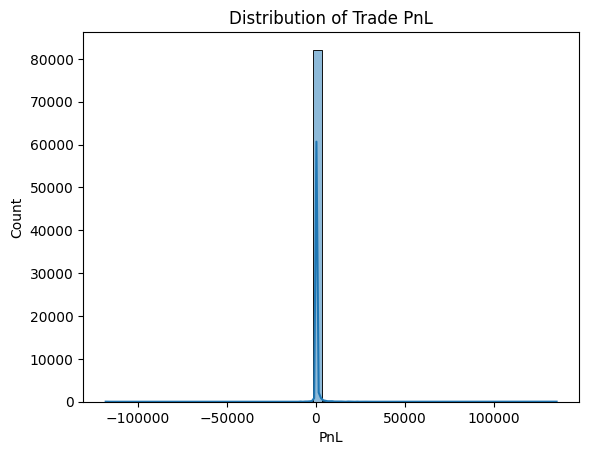

In [151]:
sns.histplot(trades_df['closed pnl'], bins=50, kde=True)
plt.title("Distribution of Trade PnL")
plt.xlabel("PnL")
plt.show()


Long vs Short Performance

In [153]:
side_performance = trades_df.groupby('side')['closed pnl'].mean()
side_performance


,closed pnl
side,
BUY,77.040542
SELL,104.552302


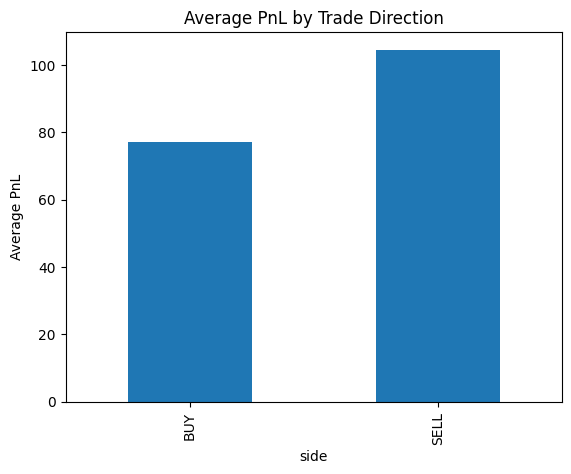

In [154]:
side_performance.plot(kind='bar', title="Average PnL by Trade Direction")
plt.ylabel("Average PnL")
plt.show()

Win Rate Visualization

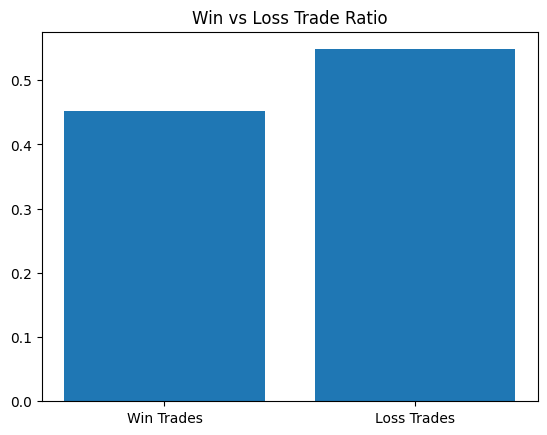

In [155]:
win_rate = trades_df['is_win'].mean()

plt.bar(['Win Trades', 'Loss Trades'], [win_rate, 1 - win_rate])
plt.title("Win vs Loss Trade Ratio")
plt.show()


SENTIMENT VISUALIZATION

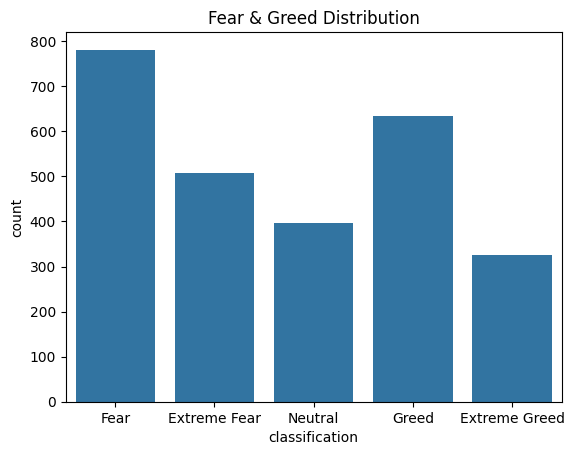

In [156]:
sns.countplot(data=sentiment_df, x='classification')
plt.title("Fear & Greed Distribution")
plt.show()


 # Create Profitability Buckets
 step:1

In [157]:
# Create profitability buckets
trades_df['pnl_bucket'] = pd.cut(
    trades_df['closed pnl'],
    bins=[-np.inf, 0, trades_df['closed pnl'].quantile(0.75), np.inf],
    labels=['loss', 'small_profit', 'high_profit']
)

trades_df['pnl_bucket'].value_counts()


,count
pnl_bucket,
loss,45265
high_profit,20647
small_profit,16677


step:2
Prepare Features

In [158]:
X = trades_df[['is_long', 'is_win']]
y = trades_df['pnl_bucket']


In [159]:
X = X.astype(int)


STEP 3: Train Simple Model

In [160]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

 high_profit       0.55      1.00      0.71      5162
        loss       1.00      1.00      1.00     11317
small_profit       0.00      0.00      0.00      4169

    accuracy                           0.80     20648
   macro avg       0.52      0.67      0.57     20648
weighted avg       0.69      0.80      0.73     20648



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# STEP 1: Create Volatility Proxy

In [161]:
trades_df['abs_pnl'] = trades_df['closed pnl'].abs()

vol_threshold = trades_df['abs_pnl'].median()

trades_df['volatility_regime'] = np.where(
    trades_df['abs_pnl'] > vol_threshold,
    'high_volatility',
    'low_volatility'
)

trades_df['volatility_regime'].value_counts()


,count
volatility_regime,
low_volatility,41296
high_volatility,41293


STEP 2: Train Model

In [162]:
X = trades_df[['is_long', 'is_win']]
y = trades_df['volatility_regime']

X = X.astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test)))


                 precision    recall  f1-score   support

high_volatility       0.99      0.90      0.94     10323
 low_volatility       0.91      0.99      0.95     10325

       accuracy                           0.95     20648
      macro avg       0.95      0.95      0.95     20648
   weighted avg       0.95      0.95      0.95     20648



# CLUSTERING TRADERS INTO BEHAVIORAL ARCHETYPES

STEP 1: Create Behavioral Feature Set

In [164]:
behavior_df = trades_df.groupby('side').agg(
    avg_pnl=('closed pnl', 'mean'),
    win_rate=('is_win', 'mean'),
    trade_count=('closed pnl', 'count')
).reset_index()

behavior_df


,side,avg_pnl,win_rate,trade_count
0,BUY,77.040542,0.257291,40600
1,SELL,104.552302,0.640120,41989


STEP 2: Normalize Features

In [165]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(
    behavior_df[['avg_pnl', 'win_rate', 'trade_count']]
)


STEP 3: KMeans Clustering

In [166]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
behavior_df['cluster'] = kmeans.fit_predict(X_scaled)

behavior_df


,side,avg_pnl,win_rate,trade_count,cluster
0,BUY,77.040542,0.257291,40600,0
1,SELL,104.552302,0.640120,41989,1
